# one dim bandwidth sweep

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD
from utils import dict_concatenate, dict_mean

In [2]:
n=100
d=1
stepsize = 0.01
L = 100
grid_length = 25

In [3]:
bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)
from utils import log_gaussian_mixture
logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWar

In [4]:
svgd_fix = SVGD(logp=logp, n_iter=L, adaptive_kernel=False, get_bandwidth=None)

In [5]:
def get_mse_dict(x0):
    mse_dict = {
        "E[x]": [],
        "E[x^2]": [],
        "E[cos(wx)]": []
        }
    for h in bandwidth_grid:
        xout, log = svgd_fix.svgd(x=x0, stepsize=stepsize, bandwidth=h)
        assert not np.any(np.isnan(xout))

        mse1 = (np.mean(xout, axis=0) - 2/3)**2
        mse2 = (np.mean(xout**2, axis=0) - 5)**2
        w = random.normal(rkey, (1,))
        mse3 = (np.mean(np.cos(w * xout), axis=0) - np.exp(-w**2 / 2))**2
        mses = [mse1, mse2, mse3]

        for i, k in enumerate(mse_dict.keys()):
            mse_dict[k].append(mses[i])
    
    for k, v in mse_dict.items():
        mse_dict[k] = np.array(v)
            
    return mse_dict

In [6]:
m = 24
mse_dicts = []
for seed in range(m):
    rkey = random.PRNGKey(seed)
    x0 = random.normal(rkey, shape=(n, d)) - 10
    mse_dict = get_mse_dict(x0)
    mse_dicts.append(mse_dict)

In [7]:
mse_dicts[1]["E[x]"].shape

(25, 1)

In [8]:
mse_dict = dict_mean(mse_dicts)

In [9]:
mse_dict["E[x]"].shape

(25, 1)

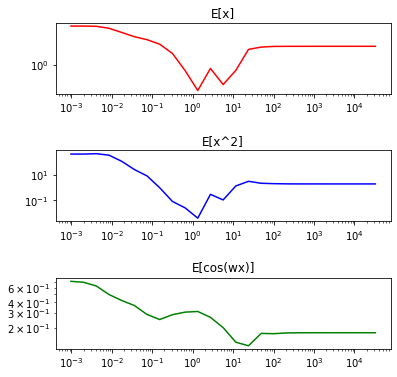

In [10]:
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
plt.subplots_adjust(hspace=0.8)
col = ["r", "b", "g"]
for i, key in enumerate(mse_dict.keys()):
    plt.subplot(f"31{i+1}")
    plt.title(key)
    plt.plot(bandwidth_grid, mse_dict[key], col[i])
    plt.xscale('log')
    plt.yscale('log')

# same thing, but in two dims

In [11]:
n=100
d=2
stepsize = 0.01
L = 100
grid_length = 25

In [12]:
bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)
bandwidth_grid = bandwidth_grid[:, np.newaxis]
for _ in range(d-1):
    bandwidth_grid = np.concatenate([bandwidth_grid, np.ones((grid_length, 1))], axis=1)
bandwidth_grid.shape

from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [13]:
def get_mse_dict2(x0):
    mse_dict = {
        "E[x]": [],
        "E[x^2]": []
#         "E[cos(wx)]": []
        }
    for h in bandwidth_grid:
        xout, log = svgd_fix.svgd(x=x0, stepsize=stepsize, bandwidth=h)
        assert not np.any(np.isnan(xout))

        mse1 = (np.mean(xout, axis=0) - 0)**2
        mse2 = (np.mean(xout**2, axis=0) - 1)**2
#         w = random.normal(rkey, (1,))
#         mse3 = (np.mean(np.cos(w * xout), axis=0) - np.exp(-w**2 / 2))**2
#         mses = [mse1, mse2, mse3]

        for i, k in enumerate(mse_dict.keys()):
            mse_dict[k].append(mses[i])
    
    for k, v in mse_dict.items():
        mse_dict[k] = np.array(v)
            
    return mse_dict

In [14]:
m = 24
mse_dicts2 = []
for seed in range(m):
    rkey = random.PRNGKey(seed)
    x0 = random.normal(rkey, shape=(n, d)) - 10
    mse_dict = get_mse_dict2(x0)
    mse_dicts2.append(mse_dict)

AssertionError: 

In [ ]:
mse_dict2 = dict_mean(mse_dicts2)

In [ ]:
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
plt.subplots_adjust(hspace=0.8)
col = ["r", "b", "g"]
l = len(mse_dict2)
for i, key in enumerate(mse_dict.keys()):
    plt.subplot(f"{l}1{i+1}")
    plt.title(key)
    plt.plot(bandwidth_grid[:, 0], mse_dict[key], col[i])
    plt.xscale('log')
    plt.yscale('log')